In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=2b76834c2689352b10826302070c728d402c7585cf271ba7c2f8a6c9d150978d
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam


In [ ]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
model_ft = models.resnet152(weights='IMAGENET1K_V2')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)
model = torch.load("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/models/MALARIA_BOUNDING_DATASET_94.67resnet152.pt")
model_ft.load_state_dict(model)
model_ft.eval()

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 87.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

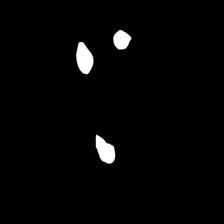

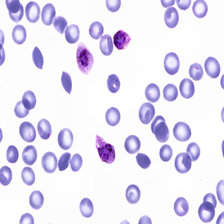

In [ ]:
imgtransform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   ])

iptimage=Image.open("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/CoolMalariaBox/malaria/images/val/Malaria/0d2aba33-6920-4001-bd54-59fe0bf9f50e.png")
SAM = Image.open("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/malaria_SAM/0d2aba33-6920-4001-bd54-59fe0bf9f50e.png")
img_np = np.array(iptimage)
img_resized = cv2.resize(img_np, (224, 224))
img_np = np.array(img_resized).astype(np.float32) / 255.0

input_tensor = imgtransform(iptimage)
input_tensor = input_tensor.unsqueeze(0) #add batch dimension
Image.fromarray(img_resized)
display(SAM.resize((224,224)), iptimage.resize((224,224)))

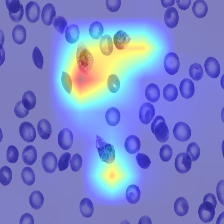

In [ ]:
target_layers = [model_ft.layer4[-1]]
cam = GradCAMPlusPlus(model=model_ft, target_layers=target_layers, use_cuda=True)
targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
Image.fromarray(visualization)


In [ ]:
!pip install torcheval
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 13.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 33.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.patches as patches
import random
from torcheval.metrics.functional import binary_auprc
from torchmetrics import PrecisionRecallCurve

In [ ]:
def auc_judd(gt, pred):

    gt_binary = np.where(gt >= 0.5, 1, gt)
    gt_binary = np.where(gt_binary < 0.5, 0.0, gt_binary)
    
    thresholds = []

    for i in range(0, gt_binary.shape[0]):
        for j in range(0, gt_binary.shape[1]):
            if gt_binary[i][j] > 0.5:
                thresholds.append(pred[i][j])
    
    num_fixations = len(thresholds)
    area = []
    area.append((0.0, 0.0))

    print(gt_binary)

    for thresh in thresholds:
        temp = np.zeros(pred.shape)
        temp[pred >= thresh] = 1

        #print("Temp: ", np.add(temp, gt_binary))

        num_overlap = np.where(np.add(temp, gt_binary) == 2)[0].shape[0]
        tp = num_overlap/num_fixations

        fp = (np.sum(temp) - num_overlap)/((np.shape(gt_binary)[0] * np.shape(gt_binary)[1]) - num_fixations)

        area.append((round(fp, 4), round(tp, 4)))

    
    area.append((1.0, 1.0))
    print(area)

    plt.scatter(*zip(*area))
    plt.show()

    area.sort(key = lambda x:x[0])
    tp_list = [x[1] for x in area]
    fp_list = [x[0] for x in area]

    print("AUC Judd: ", np.trapz(np.array(tp_list), np.array(fp_list)))

(224, 224)
(224, 224)


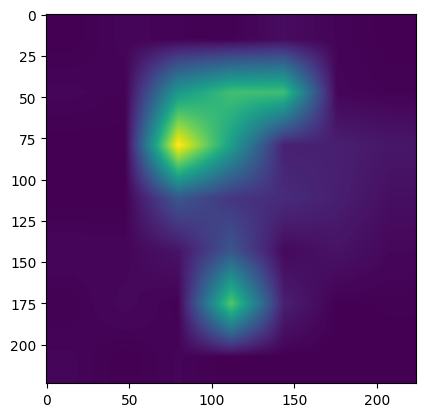

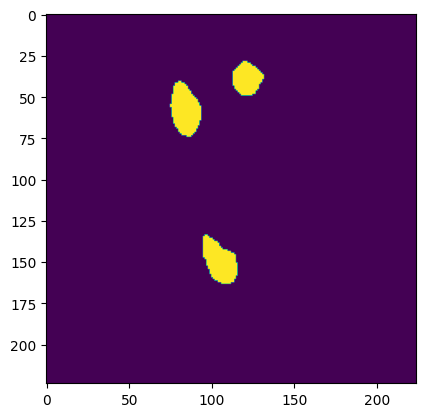

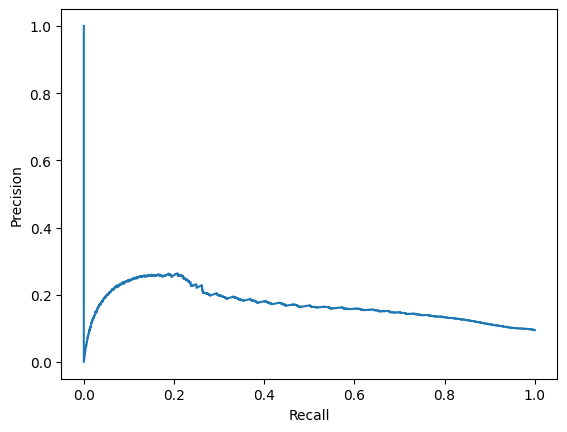

AUPRC:  tensor(0.1700)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[(0.0, 0.0), (0.1268, 0.8127), (0.1267, 0.8109), (0.1266, 0.8101), (0.1184, 0.7858), (0.1182, 0.7849), (0.118, 0.784), (0.1179, 0.7832), (0.1177, 0.7823), (0.1174, 0.7814), (0.1102, 0.7615), (0.11, 0.7589), (0.1099, 0.7572), (0.1099, 0.7563), (0.1097, 0.752), (0.1096, 0.7511), (0.1095, 0.7502), (0.1093, 0.7493), (0.1025, 0.732), (0.1024, 0.7311), (0.1023, 0.7303), (0.1021, 0.7285), (0.102, 0.7277), (0.1019, 0.7251), (0.1019, 0.7242), (0.1018, 0.7233), (0.1016, 0.7225), (0.1015, 0.7207), (0.1013, 0.7181), (0.0951, 0.7016), (0.095, 0.7008), (0.0949, 0.6999), (0.0948, 0.699), (0.0948, 0.6982), (0.0946, 0.6964), (0.0946, 0.6956), (0.0945, 0.6947), (0.0943, 0.6921), (0.0942, 0.6912), (0.0941, 0.6904), (0.094, 0.6895), (0.094, 0.6886), (0.0884, 0.6704), (0.0883, 0.6687), (0.0882, 0.6678), (0.0881, 0.667), (0.088, 0.

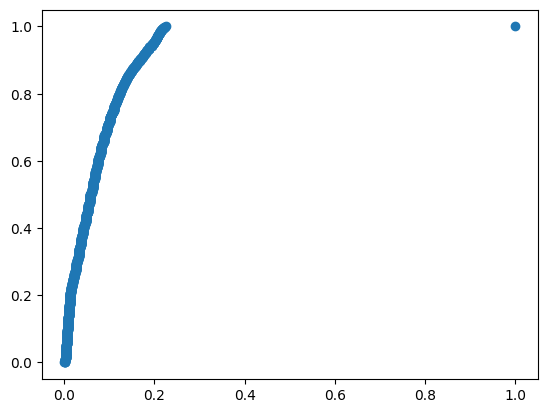

AUC Judd:  0.9278494999999999


In [ ]:
gt = np.array(SAM.resize((224, 224)))
gt = np.where(gt > 1, 1, gt)

print(gt.shape)
print(grayscale_cam.shape)


fig, ax = plt.subplots()
ax.imshow(grayscale_cam)

fig2, ax2 = plt.subplots()
ax2.imshow(gt)

gc_tensor = torch.tensor(grayscale_cam.flatten())
gt_tensor = torch.tensor(gt.flatten())

auprc = binary_auprc(gc_tensor, gt_tensor)

pr_curve = PrecisionRecallCurve(task="binary")
precision, recall, thresholds = pr_curve(gc_tensor, gt_tensor)

plt.show()

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()
print("AUPRC: ", auprc)

auc_judd(gt, grayscale_cam)
